# Get the Taste

## 1. Draw Primitive H-R Diagram

You will now learn what photometry can show you. The first trial is to draw the H-R diagram! (Benefited from [Jason Shilling Kendall](http://www.jasonkendall.com/WPU/HRDiagram/))

You may have seen this on textbooks, but now we will draw primitive H-R diagram from WFPC2 F450W and F814W filters of Hubble Space Telescope (HST) archieved data.

### Download Data
First, go to [this link](http://hla.stsci.edu/). Click on the "Enter Site Here", and search for "M80". You will see a lot of results. Type "11233" to the "PropID" column, "WFPC2" to "Detector" column, and hit Enter. 

Find the data with "NExposures" = 6 and "VisitNum" = 6. There should be only two data.

At the last part of the columns, you will see "DAOCat", which is the primitive photometry results using DAOPHOT algorithm. "SEXCat" is the one used SExtractor algorithm. We will use "DAOCat": click on the "DAOphot" links of the two images. The catalogs will be added to your "cart". Above the table, you have "Cart" tab. Go there and download the data. I have saved the data with name "F450W.dat" and "F814W.dat", respectively.


### Play with Image
From the STScI website, you can play with image by the tools they provide. For the corresponding images, click on the "Display" and "PlotCat" links. You will intuitively know what each buttons on the pop-up window are. Play with it!

* **Question**: Go to "PlotCat" and check on DAOphot and SExtractor. Why do you think the results differ?
  * Hint: Click on the "?Help" icon on the top-right part of the pop up window.
  * Hint: Why did they implement both, not one of them?
 
* **Question**: The target is a globular cluster. Why do you think it doesn't look like a GC? Why did people took the image like this?

### Drawing H-R Diagram

If you've downloaded the data, go to the directory and make a script to plot a H-R diagram. For my case, I did it like this:


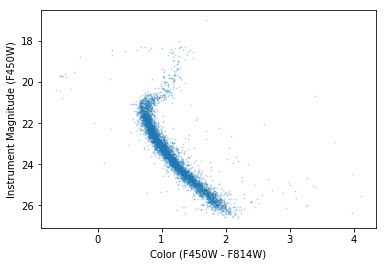

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Load data
F450 = np.loadtxt('HST_Tutorial/F450W.dat') # NumPy automatically skips the commented rows.
F814 = np.loadtxt('HST_Tutorial/F814W.dat')

mask  = np.zeros(len(F450)).astype(bool)
color = np.zeros(len(F450))


# Get color indices of the "same" stars in two filter images
for i in range(0, len(F450)):
    ID450 = F450[i,4]
    for j in range(0, len(F814)):
        ID814 = F814[j,4]
        if ID450 == ID814:
            mask[i]  = True
            color[i] = F450[i,5] - F814[j,5]
            break # Once the matched item is found from F814, go to next star of F450.

# Plot and show
plt.plot(color[mask], F450[mask,5], 'o', ms=1, alpha=0.2)
plt.xlabel('Color (F450W - F814W)')
plt.ylabel('Instrument Magnitude (F450W)')
plt.gca().invert_yaxis()
plt.show()

In the example, I used `mask` array to select only the stars in F450 which have counterpart in F814.

* **Question**: What do you think the abscissa and ordinate mean?
* **Question**: Why could I generate such a good-looking H-R diagram? 
  * Hint: If you do the same thing for ground-based observation data, you may get uglier result.

Below is the plot of magnitude error plot.

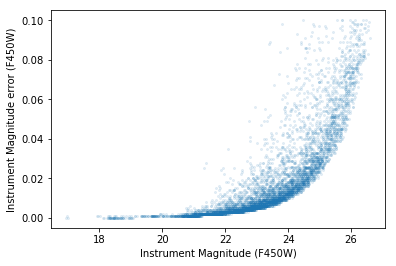

In [2]:
plt.plot(F450[:,5], F450[:,6], 'o', ms=2, alpha=0.1)
plt.xlabel('Instrument Magnitude (F450W)')
plt.ylabel('Instrument Magnitude error (F450W)')
plt.show()

* **Question**: For F450W data, the above is the plot showing magnitude and error. Why do you think this shape appears?
 * Hint: Msky and Stdev of the original file means the estimated sky and sky standard deviation values. Flux is of course the flux of the star in certain unit. With this knowledge, refer to [STScI IRAF PHOT manual](http://stsdas.stsci.edu/cgi-bin/gethelp.cgi?phot), the section "OUTPUT".
 

## 2. Elliptical Galaxy

As a second example, I will show you how to quantitatively describe an elliptical galaxy using imaging mode data.


### Download Data
At the same site as above, search for M87. Type "hst_11216_51_wfpc2_f606w_pc" to the "Dataset" column. Only one image will show up. This time, click on "FITS" in the "Retrieve" column. Download it. I saved it as "M87.fits".

### Play with Image
First of all, HST FITS image has extension! If you do not know what this means, see pp.20-21 of [this document][01]. So to see the images, use

```bash
ginga M87.fits[1] M87.fits[2] M87.fits[3] &
```

The image [0] is called the "primary", and it contains the header information only. It doesn't have image data. [1] is the actual image we may be interested in, and named as "SCI". [2] and [3] are the weight and context images, named "WHT" and "CTX". For the detailed explanation for these images, refer to the section 5.4.6.3. of [this document][02]. These are kind of a byproduct after [drizzle][03] image reduction.

[01]: http://www.stsci.edu/hst/HST_overview/documents/datahandbook/hstdh_intro.pdf
[02]: http://www.stsci.edu/hst/HST_overview/documents/multidrizzle/ch55.html
[03]: https://en.wikipedia.org/wiki/Drizzle_(image_processing)

The following is an example of doing `pick` on `ginga`, and you can see that the object has quite circular shape from the FWHM fitting. 

<img src='HST_Tutorial/M87_ginga.png' width=800>

* **Question** What is the bar-like feature near the elliptical galaxy? Do you think it is going in to? Or is it coming out from the galaxy?
* **Question** Why do you think the image is slightly "rotated" by default?
 * Hint: look at the top-left panel (small image) of the screenshot




### Analyze
Now I want to load the image in Python for analysis. 

Before doing so, do the `pick` to some of the stars in the image and find the general FWHMs. You may find it to be something like 2.xx pixels. I will use `FWHM = 2` pixels is the representative value.

I want to do the following:

1. Detect sources using (normalized) 2D Gaussian kernel with FWHM=2 having 5x5 size.
 * Sources are considered as *detected* if 5+ nearby pixels (in 3x3 region if `connectivity=8`, which is the default of SExtractor) after convolution have value > `threshold`.
 * The 5-pixel criterion comes from considering a `+` shaped source.
 * `threshold` is calculated as 3 times the background uncertainty.
 * Since it's a very primitive exercise, I want to use median/stdev of the image after sigma clipping (3-sigma 10-iters) as background level and its uncertainty.
2. For each source, I can use `photutils.source_properties` to see some morphological parameters, similar to SExtractor. 

For detection, I will use [`photutils.detect_sources`](https://photutils.readthedocs.io/en/stable/api/photutils.segmentation.detect_sources.html#photutils.segmentation.detect_sources).


Filename: HST_Tutorial/M87.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     426   ()      
  1  SCI         ImageHDU       110   (850, 850)   float32   
  2  WHT         ImageHDU       130   (850, 850)   float32   
  3  CTX         ImageHDU       129   (850, 850)   int32   
bkg = 0.211 +- 0.748
threshold = 2.454


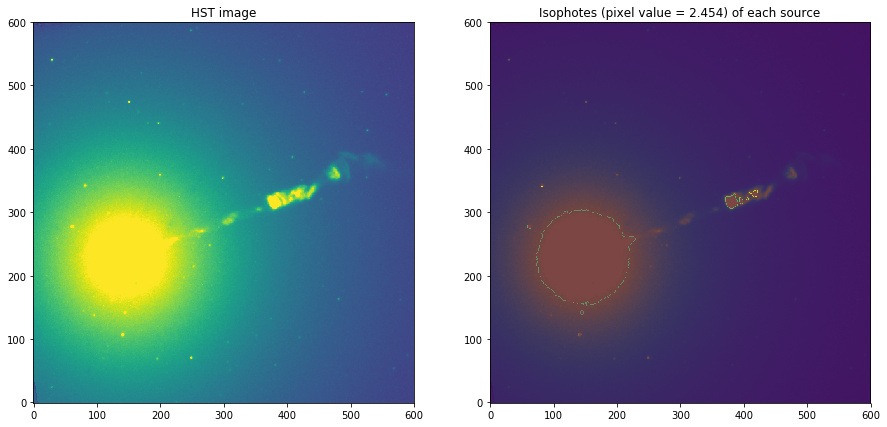

In [3]:
from astropy.io import fits
from astropy.convolution import Gaussian2DKernel
from astropy.stats import sigma_clipped_stats
from photutils import detect_sources

hduList = fits.open('HST_Tutorial/M87.fits')
image   = hduList['SCI'].data[100:-150, 100:-150]
hduList.info()

# for a very simple analysis purpose, 
# I will regard the median as sky (background) and std as the background fluctuation.
avg, med, std = sigma_clipped_stats(image, sigma=3., iters=10)
threshold     = med + 3.0 * std
print('bkg = {0:.3f} +- {1:.3f}\nthreshold = {2:.3f}'.format(med, std, threshold))

# From Ginga, we primitively obtained FWHM = 2.
# Let me generate normalized Gaussian kernal of 5x5 size 
# (similar to SExtractor file `gauss_2.0_5x5.conv`)
sigma = 2.3548 * 2
gauss = Gaussian2DKernel(stddev=sigma, x_size=5, y_size=5)
gauss.normalize()

# Detect!
sources = detect_sources(image, threshold=threshold, npixels=3, filter_kernel=gauss, connectivity=8)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(image, origin='lower', vmin=med-2*std, vmax=avg+3*std)
ax1.set_title('HST image')
ax2.imshow(image, origin='lower', vmin=med-2*std, vmax=avg+3*std)
ax2.imshow(sources.outline_segments(), origin='lower', alpha=0.7)
ax2.set_title('Isophotes (pixel value = {:.3f}) of each source'.format(threshold))
plt.show()

You can see some of the stars are detected and the "feature" is also detected as some different sources. You can see how the detection changes when you tune `threshold`, `npixel`, `connectivity` (only 4 and 8 available), etc.

* **Question**: Why do you think I cropped the image with ~100 pixel bezel?
* **Question**: How do you think about the sky subtraction? Do you think it is reliable? And do you think the result is reliable?
* **Question**: Why did I multiplied 2.3548 to x and y stddev?

* **TIP**: If 2+ sources are overlapping, they are considered as one single object in this case. I currently am interested in the largest source, the galaxy, so I'm not much interested in this issue for now. To avoid this situation, the technique called **deblending** is used. It is also widely used in SExtractor community, and you can try the photutils version: see [here](https://photutils.readthedocs.io/en/stable/photutils/segmentation.html#source-deblending)


Now that we have detected the source, I want to know the morphological property of the largest source, i.e., the galaxy. First, let me list all the data in an ugly format, and show you how to extract the parameters:

In [4]:
from photutils import source_properties, properties_table
source_props = source_properties(image, sources)
source_table = properties_table(source_props)
print(source_table)

print('\nExtracting the fitted parameter of id=1, xcentroid:')
print('\t', source_props[0].xcentroid)
print('\tType:', type(source_props[0].xcentroid))
print('\t', source_props[0].xcentroid.value)
print('\tType:', type(source_props[0].xcentroid.value))

print('\nExtracting the fitted parameter of id=0, centroid:')
print('\t', source_props[0].centroid.value)
print('\tNote it is in the form of "y" and then "x"!!')

 id   xcentroid     ycentroid   ...        cxy               cyy       
         pix           pix      ...      1 / pix2          1 / pix2    
--- ------------- ------------- ... ----------------- -----------------
  1 141.176375775 107.288246059 ...  -0.0995329986832     0.55543214519
  2 144.487770602 141.967603735 ... -0.00606900928328    0.332463796679
  3 147.180533429 229.926869978 ... -2.4109427507e-05 0.000845524774603
  4  61.549947673 277.176956182 ...  -0.0237574147774    0.375578864791
  5 379.648116733 316.272235776 ...  0.00909362567613   0.0416522481635
  6 394.725682546 317.816367219 ...    0.179640039718     0.16131243371
  7 405.045251064 320.845455313 ...   -0.231122870715    0.615246489824
  8 415.541699081 329.710492397 ... -0.00277020014779    0.152479099784
  9  81.665132008 341.707828938 ...   -0.340050497064      1.1701627098

Extracting the fitted parameter of id=1, xcentroid:
	 141.17637577507736 pix
	Type: <class 'astropy.units.quantity.Quantity'>
	 141.176

In other words, you can utilize the ones obtained directly from the table, e.g., `source_props[0].xcentroid`, as the Astropy Quantity. If you just want a float value, you can add `.value` after that.

Now, how many information is saved in the `source_props`? All the information and its meaning and discription can be found at [here](https://photutils.readthedocs.io/en/stable/api/photutils.segmentation.SourceProperties.html#photutils.segmentation.SourceProperties).

Some important ones are:

* `centroid`: The center of the source in `(y, x)` format.
* `xcentroid`, `ycentroid`: To compensate the `(y, x)` output from `centroid`.
* `bbox`: The box region in `(ymin, xmin, ymax, xmax)` format. Can be used to crop the image to contain only the source you are interested in.
* `data_cutout`: The code, e.g., 
``` python
plt.imshow(source_props[2].data_cutout)
```
will show the `bbox`-cropped region only. The `cutout_centroid` is equivalent position to the `centroid` *on the cutout image*.
* `source_sum`: The pixel sum within the source. 
* `elongation`, `ellipticity`, and `eccentricity`: See the document above for the definitions. 
* `orientation`: The rotation angle of the major axis with respect to the image X axis in counter clockwise.


* **Question**: Why do you think there are `(x, y)` and `(y, x)` conventions, not just `(x, y)`?

* **TIP**: I strongly recommend you NOT to use `source_sum_err` directly, as it may not contain the information of gain, readout noise, and uncertainties from sky estimation, unless you very carefully input all such things.


The galaxy is the one with `id=3`, or with index `2`. I will print out the value integer part of `10*ellipticity`, which is used for the Hubble sequence and `orientation`.

In [5]:
import astropy.units as u
E = 10*source_props[2].ellipticity
print('Class of E{0:.0f}'.format(E))
print('Orientation\n\t', source_props[2].orientation.to(u.deg))


Class of E0
Orientation
	 33.16038558171982 deg


* **Question**: In this calculation, I used the isophote of `background + 3 * sigma`. Do you think it will work for most cases?